## APPLIED MACHINE LEARNING PROJECT

<h1 align = "center" style = "color: Green; font-size:30pt">Life Expectancy Prediction Project</h1>

# 1  Looking at the Big Picture — Framing the Problem
*(Life-Expectancy Project)*

## 1.1 Business Objective
National health authorities and development agencies need a **reliable forward-looking indicator of overall public-health quality**.  
Accurate *life expectancy at birth* predictions let them:

* forecast healthcare demand and pension liabilities;
* compare progress toward UN Sustainable Development Goals (SDG 3);
* prioritise interventions in countries where gains are lagging.

## 1.2 Problem Type
The target variable **Life expectancy (years)** is continuous ⇒  
→ **Supervised • Batch • Model-based • Regression task**

## 1.3 Success Metric
we use **Root-Mean-Squared Error (RMSE)** because;
* it is in the same unit (years) as the target — easy for policy-makers to understand;  
* the squared term penalises large medical-policy errors more than small ones, which aligns with risk tolerance.

---

**Goal statement**

> *“Train a regression model that predicts a country’s average life expectancy for a given year using the WHO/UN blended dataset, achieving a test-set RMSE ≤ 3.5 years while maintaining interpretability for policy briefs.”*

---

* Process ==>: Get the Data → Investigate & Visualise → Prepare the Data → Select & Train a Model → Fine-Tune → Evaluate on the Test Set *


In [1]:
#Import Relevant Libraries

#Getting Started Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px #library for beautiful plots
from pathlib import Path #to handle file/folder paths in a clean way

# Model Selection and Hyperparameter tuning
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV

# Importing the neccesary sk-learn classes/objects
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## Importing the neccesary models and error metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


#Import time model for estimating the time it takes models to evaluate RMSE
import time

#Saving Model
import joblib


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE) # to add reproducibility

#  This is to Show full dataframes during EDA
pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 2) # set to 2 decimal


# 2  Get the Data

We work with the **WHO / UN Life-Expectancy dataset (22 columns, 2 938 rows, years 2000-2015)**.  
To avoid *data-leakage* and to keep our results reproducible, we do the following:

1. **Load the raw CSV** into a pandas DataFrame.  
2. **Strip hidden spaces** from column names (the file contains trailing blanks) this is done to prevent ==> key errors, bugs and typos.  
3. **Create a single test set once** using an 80 / 20 split **stratified** on an engineered `income_cat` attribute (binned ‘Income composition of resources’) so that both sets keep the same wealth distribution.


In [2]:
# 2.1  Read CSV
DATA_PATH = Path("Applied_ML_Assignment")
df = pd.read_csv("Life_Expectancy_Data.csv")
df.columns = df.columns.str.strip()        # clean names

# # 2.2  DROP rows that lack the strat attribute (167 rows ≈ 6 %)
df = df.dropna(subset=["Income composition of resources"]).copy()

# # 2.3  Create helper stratification column (include the lowest value, extend top bin)
df["income_cat"] = pd.cut(
    df["Income composition of resources"],
    bins=[0., 0.2, 0.4, 0.6, 0.8, np.inf],   # last bin is 0.8 – ∞
    labels=[1, 2, 3, 4, 5],
    include_lowest=True                      # put 0.0 into bin 1
)



In [3]:
print("Any NaNs left in income_cat? ->", df["income_cat"].isna().sum()) #returns a Boolean Series that is True for every row where income_cat is NaN


Any NaNs left in income_cat? -> 0


In [4]:
# 2.4  One-off stratified 80 / 20 split (reproducible)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.20,
                               random_state=RANDOM_STATE)

for train_idx, test_idx in split.split(df, df["income_cat"]):
    strat_train_set = df.iloc[train_idx].drop("income_cat", axis=1)
    strat_test_set  = df.iloc[test_idx].drop("income_cat", axis=1)


print(f"Train size: {strat_train_set.shape},  Test size: {strat_test_set.shape}")


Train size: (2216, 22),  Test size: (555, 22)


# 3  Investigate & Visualise

the three-step exploratory :

1. **Quick structure check** – `info()`, `describe()`, missing-value heat.
2. **Univariate view** – histograms of every numerical feature (log-scale for heavy-tailed counts such as *Measles*).
3. **Multivariate view**  
   * Pearson correlation matrix heat-map.  
   * Scatter-plots of the three strongest ± correlations with the target.  
   * Early **feature-engineering ideas** recorded for the next section.

> *All plots use the training set only to respect the “no peeking at test data” rule *


In [5]:
# Basic structure
train = strat_train_set.copy()   # To work only on the training data

print("--- DataFrame info() ---")
train.info()
print("\n--- describe() (numeric) ---")
display(train.describe().T)

# Quick look at categorical variable
print("\nStatus value counts:")
print(train["Status"].value_counts())


--- DataFrame info() ---
<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 2536 to 980
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2216 non-null   object 
 1   Year                             2216 non-null   int64  
 2   Status                           2216 non-null   object 
 3   Life expectancy                  2213 non-null   float64
 4   Adult Mortality                  2213 non-null   float64
 5   infant deaths                    2216 non-null   int64  
 6   Alcohol                          2065 non-null   float64
 7   percentage expenditure           2216 non-null   float64
 8   Hepatitis B                      1816 non-null   float64
 9   Measles                          2216 non-null   int64  
 10  BMI                              2190 non-null   float64
 11  under-five deaths                2216 non-null   int64  
 12

,count,mean,std,min,25%,50%,75%,max
Year,2216.0,2.01e+03,4.61e+00,2000.00,2004.00,2.01e+03,2.01e+03,2.02e+03
Life expectancy,2213.0,6.94e+01,9.33e+00,39.00,63.50,7.22e+01,7.55e+01,8.90e+01
Adult Mortality,2213.0,1.64e+02,1.23e+02,1.00,75.00,1.44e+02,2.25e+02,7.23e+02
infant deaths,2216.0,2.94e+01,1.23e+02,0.00,0.00,3.00e+00,1.90e+01,1.80e+03
Alcohol,2065.0,4.50e+00,4.03e+00,0.01,0.76,3.62e+00,7.51e+00,1.79e+01
percentage expenditure,2216.0,7.66e+02,1.96e+03,0.00,9.72,7.61e+01,4.91e+02,1.91e+04
Hepatitis B,1816.0,8.08e+01,2.51e+01,2.00,77.00,9.20e+01,9.70e+01,9.90e+01
Measles,2216.0,2.20e+03,1.10e+04,0.00,0.00,1.50e+01,3.42e+02,2.12e+05
BMI,2190.0,3.84e+01,1.99e+01,1.00,19.10,4.38e+01,5.60e+01,8.33e+01
under-five deaths,2216.0,4.06e+01,1.66e+02,0.00,0.00,3.00e+00,2.40e+01,2.50e+03



Status value counts:
Status
Developing    1849
Developed      367
Name: count, dtype: int64


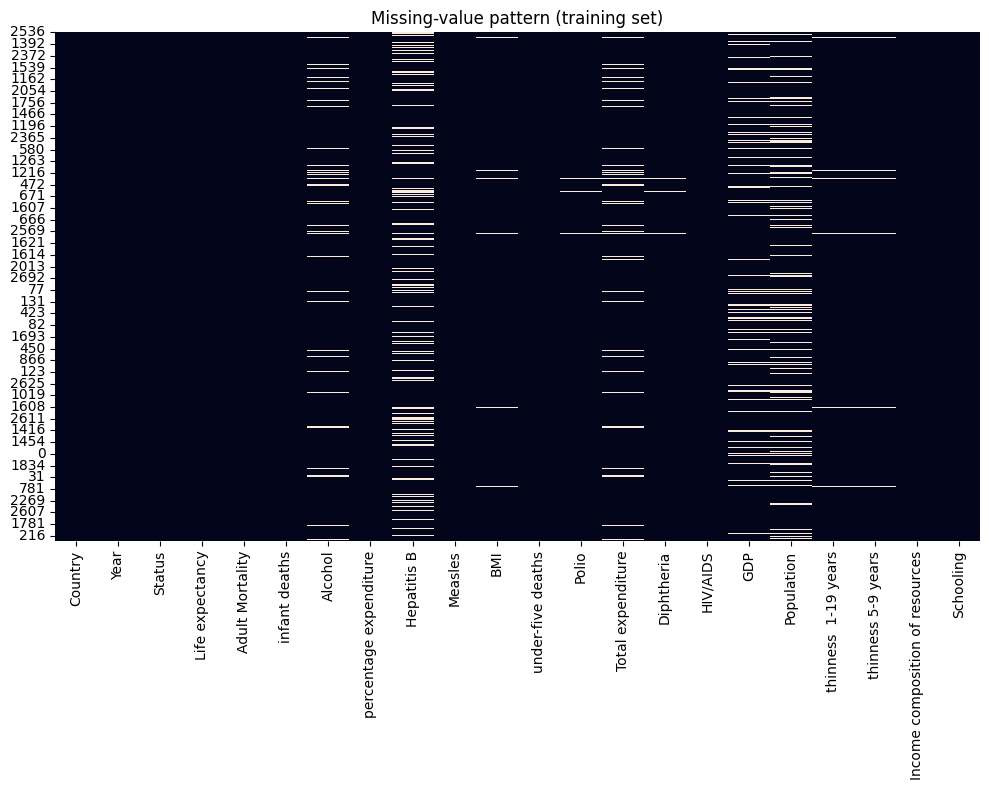

In [6]:
# Columns with lots of missing data (tall dark bands)—important for deciding an imputation strategy or whether to drop a feature.

plt.figure(figsize=(10, 8))
sns.heatmap(train.isna(), cbar=False)
plt.title("Missing-value pattern (training set)")
plt.tight_layout()
plt.show()


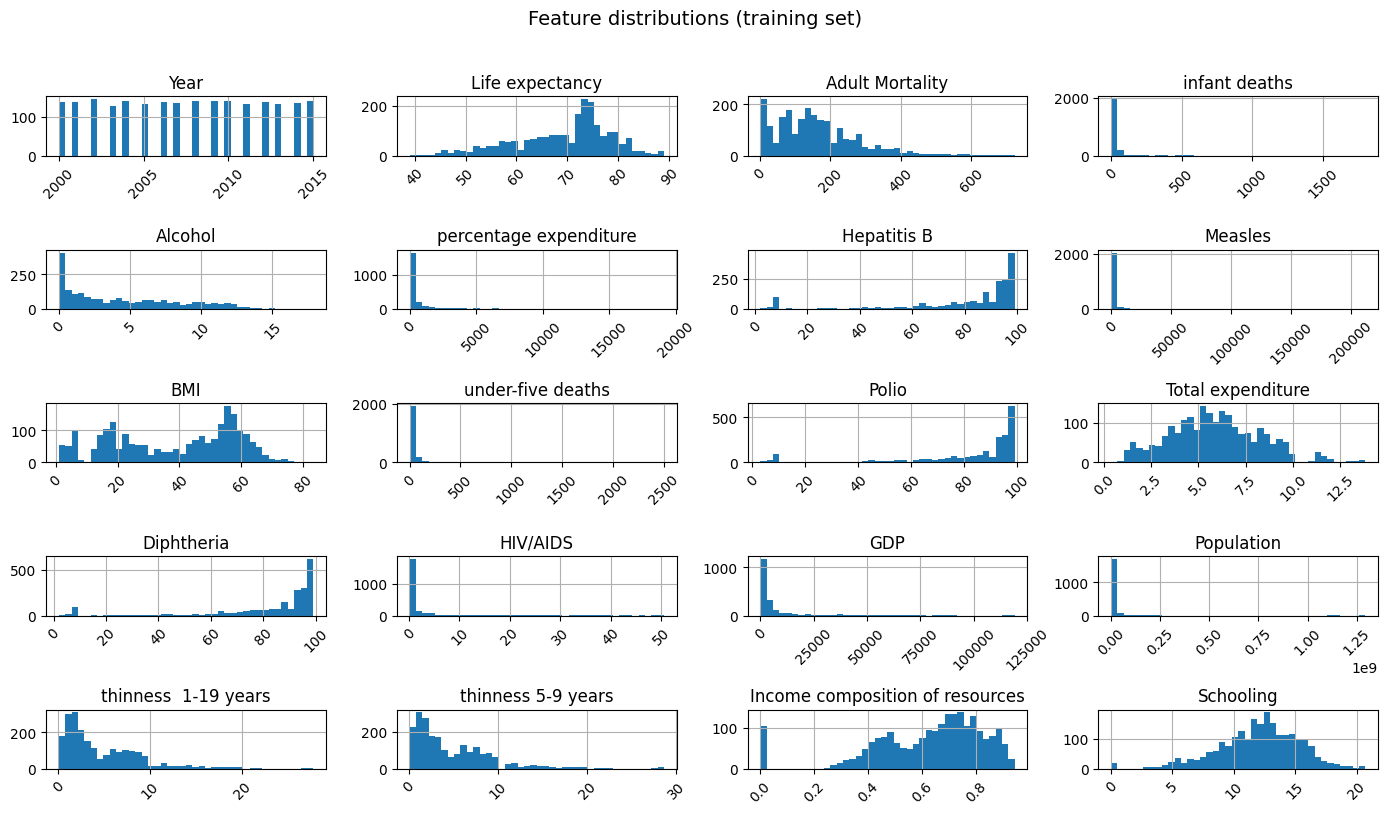

In [7]:
# Histograms for every numeric feature distribution in the training set

ax = train.hist(figsize=(14, 8), bins=40, xrot=45)  # rotate x-tick labels 
plt.suptitle("Feature distributions (training set)", y=1.02, fontsize=14)
plt.tight_layout()   # auto-pad so labels don’t collide
plt.savefig("Histogram of Features (training set)", dpi = 300)
plt.show()


In [8]:
#Correlation amongst numerical features (excluding target) visualization using plotly express
num_train = train.select_dtypes("number")
fig = px.imshow(num_train.drop(columns = 'Life expectancy').corr(), title = "Correlation amongst Numerical Features")
fig.update_layout(width = 800, height = 700)
fig.show()

In [9]:
#Investigate the correlation with target

num_train.corr()['Life expectancy'].sort_values()

Adult Mortality                   -0.69
HIV/AIDS                          -0.57
thinness  1-19 years              -0.47
thinness 5-9 years                -0.47
under-five deaths                 -0.20
infant deaths                     -0.17
Measles                           -0.14
Population                        -0.02
Year                               0.18
Total expenditure                  0.18
Hepatitis B                        0.23
Alcohol                            0.39
percentage expenditure             0.41
Polio                              0.44
Diphtheria                         0.45
GDP                                0.47
BMI                                0.57
Income composition of resources    0.73
Schooling                          0.75
Life expectancy                    1.00
Name: Life expectancy, dtype: float64

# 4  Prepare the Data

 The appropraite steps for this :

1. **Separate predictors and labels** – drop the target column *Life expectancy* from the feature set.
2. **Build a custom transformer** (`CombinedAttributesAdder`) to create new ratio features noted during EDA (e.g. birth-thinness ratio).
3. **Create two pipelines**  
   * *Numerical pipeline*: median-impute → standardise.  
   * *Categorical pipeline*: one-hot encode `Status`.
4. **Wrap both in a ColumnTransformer** so the same steps apply every time the data flow through (training, validation, test).
5. **Fit + transform the training set only**, producing `train_prepared`, the clean matrix ready for model selection.


In [10]:
# Since we cant impute Label, Drop rows where the target 'Life expectancy' is NaN
strat_train_set = strat_train_set.dropna(subset=["Life expectancy"]).reset_index(drop=True)

# Now redoing the feature/label split
train_labels   = strat_train_set["Life expectancy"]
train_features = strat_train_set.drop("Life expectancy", axis=1)


# Lists of columns
num_attribs = train_features.select_dtypes(include=["int64", "float64"]).columns
cat_attribs = ["Status"]

# Custom transformer: thinness_ratio = thinness_5-9 / thinness_1-19

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_thinness_ratio=True):
        self.add_thinness_ratio = add_thinness_ratio

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not self.add_thinness_ratio:
            return X

        idx_5_9  = num_attribs.get_loc("thinness 5-9 years")
        idx_1_19 = num_attribs.get_loc("thinness  1-19 years")

        thin5_9  = X[:, idx_5_9]
        thin1_19 = X[:, idx_1_19]

        ratio = np.divide(
            thin5_9, thin1_19,
            out=np.zeros_like(thin5_9),
            where=thin1_19 != 0
        )
        return np.c_[X, ratio]

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = num_attribs  # fallback, in case input_features not passed

        if self.add_thinness_ratio:
            return np.append(input_features, ["thinness_ratio"])
        else:
            return input_features

# Numerical and categorical pipelines
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ("std_scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Full ColumnTransformer
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])


In [11]:
train_prepared = full_pipeline.fit_transform(train_features)

print("Prepared feature matrix shape :", train_prepared.shape)
print("Example row (first 5 values)   :", train_prepared[0][:5])


Prepared feature matrix shape : (2213, 22)
Example row (first 5 values)   : [-1.62344659 -0.69659851 -0.2400394   1.74948232  2.58821196]


# 5  Select & Train Models

The workflow :

1. **Baseline model** – Linear Regression gives a quick performance floor.
2. **Non-linear tree** – Decision Tree (expected to overfit, illustrating the bias-variance trade-off).
3. **Ensemble** – Random Forest usually improves generalisation.
4. **Scale-sensitive model** – Support-Vector Regression (RBF kernel) to test a different family.

Each model is evaluated with 10-fold cross-validation on the **prepared training matrix**.  
We report the **mean RMSE ± standard deviation** across folds, then choose the most promising model for fine-tuning in Section 6.


In [12]:
#A function that evaludates the MSE of each model
def cv_rmse(model, X, y, cv=10):
    """Return negative MSE scores → convert to positive RMSE array."""
    neg_mse = cross_val_score(model, X, y,
                              scoring="neg_mean_squared_error",
                              cv=cv,
                              n_jobs=-1)
    rmse = np.sqrt(-neg_mse)
    return rmse


In [13]:
#We would also want to evaluate the time it took each model to evaluate the cross validation
results = {}

# Helper to time and compute RMSE
def evaluate_model(model, name):
    start_time = time.time()
    rmse_scores = cv_rmse(model, train_prepared, train_labels)
    elapsed_time = time.time() - start_time
    results[name] = {"rmse": rmse_scores, "time": elapsed_time}

# 5.1  Linear Regression
evaluate_model(LinearRegression(), "Linear Regression")

# 5.2  Decision Tree
evaluate_model(DecisionTreeRegressor(random_state=RANDOM_STATE), "Decision Tree")

# 5.3  Random Forest
evaluate_model(RandomForestRegressor(random_state=RANDOM_STATE), "Random Forest")

# 5.4  Support-Vector Regression (RBF kernel)
evaluate_model(SVR(kernel="rbf"), "SVR (RBF)")

# Print results
print("Model performance (10-fold CV - RMSE in years):\n")
for name, result in results.items():
    mean_rmse = result["rmse"].mean()
    std_rmse = result["rmse"].std()
    time_taken = result["time"]
    print(f"{name:18s}  {mean_rmse:5.2f} ± {std_rmse:4.2f}  (Time: {time_taken:.2f} sec)")


Model performance (10-fold CV - RMSE in years):

Linear Regression    3.79 ± 0.25  (Time: 9.31 sec)
Decision Tree        2.56 ± 0.20  (Time: 1.20 sec)
Random Forest        1.82 ± 0.20  (Time: 20.13 sec)
SVR (RBF)            3.55 ± 0.37  (Time: 2.13 sec)


# 6  Fine-Tune the Model

fine-tunning the Random-Forest baseline with a `GridSearchCV`,As follows:

* **Parameter grid**  
  * `n_estimators` – number of trees  
  * `max_features` – number of attributes tried at each split  
  * `max_depth` – tree depth (optional cap to reduce over-fit)

* **Evaluation metric** – negative MSE (converted to RMSE) across 5-fold CV on the *prepared* training data.

The grid search trains *k × m × d* forests (one per hyper-parameter combo), picks the lowest average RMSE, and exposes it as `best_estimator_`.

We then keep the best model for the final test-set evaluation in The next section


In [14]:
# 6.1  Define the parameter grid (Week-2 style)
param_grid = [
    {"n_estimators": [50, 100, 200],
     "max_features": [6, 8, 10],
     "max_depth":    [None, 20, 40]}
]

forest_reg = RandomForestRegressor(random_state=RANDOM_STATE)

grid_search = GridSearchCV(
    forest_reg,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=2
)

grid_search.fit(train_prepared, train_labels)

# 6.2  Display results
print("\nBest parameters :", grid_search.best_params_)
best_rmse = (-grid_search.best_score_)**0.5
print(f"Best CV RMSE    : {best_rmse:5.2f} years")

# 6.3  Keep the best model
final_model = grid_search.best_estimator_
joblib.dump(final_model, "random_forest_best.pkl")
print("\nSaved best model to random_forest_best.pkl")


Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best parameters : {'max_depth': 20, 'max_features': 10, 'n_estimators': 200}
Best CV RMSE    :  1.88 years

Saved best model to random_forest_best.pkl


In [15]:
#Feature Importance from our Final Model (RandomForestRegressor)
importances =  final_model.feature_importances_
fi_df = pd.Series(importances, index = full_pipeline.get_feature_names_out()).sort_values(ascending = False)
display(fi_df)

#Using plotly.express bar

fig = px.bar(
    fi_df,
    x = fi_df.index,
    y = fi_df.values,
    title = "Feature Importances with Final Model (Random Forest Regressor)"
)
fig.update_layout(xaxis_title = "Features", yaxis_title = "Feautre Importances", height = 450)
fig.show()

num__Income composition of resources    3.26e-01
num__HIV/AIDS                           2.76e-01
num__Adult Mortality                    1.43e-01
num__Schooling                          1.08e-01
num__BMI                                3.53e-02
num__under-five deaths                  1.53e-02
num__thinness 5-9 years                 1.09e-02
num__thinness  1-19 years               1.04e-02
num__GDP                                9.27e-03
num__Total expenditure                  7.87e-03
num__infant deaths                      7.60e-03
num__Alcohol                            6.86e-03
num__Diphtheria                         6.40e-03
num__Year                               6.26e-03
num__Polio                              5.21e-03
cat__Status_Developed                   5.09e-03
num__thinness_ratio                     4.58e-03
num__percentage expenditure             4.47e-03
num__Population                         3.37e-03
cat__Status_Developing                  3.28e-03
num__Measles        

# 7  Evaluate on the Test Set

Note: We touch the hold-out test data **only once**, to obtain an unbiased estimate of real-world performance.

**Steps**

1. Strip the label from `strat_test_set` to create `X_test`, keep `y_test`.
2. Run the saved `full_pipeline` to reproduce every preprocessing step.
3. Predict with the tuned Random Forest (`random_forest_best.pkl`).
4. Report the final RMSE and a 95 % confidence interval.


In [16]:
# 7.1  Separate features and labels from the untouched test set
X_test  = strat_test_set.drop("Life expectancy", axis=1)
y_test  = strat_test_set["Life expectancy"].copy()

# 7.2  Re-use the fitted preprocessing pipeline
X_test_prepared = full_pipeline.transform(X_test)

# 7.3  Load the tuned model (already saved in Section 6)
final_model = joblib.load("random_forest_best.pkl")

# 7.4  Predict and compute RMSE
final_predictions = final_model.predict(X_test_prepared)
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)

print(f"\nFinal RMSE on hold-out test set: {final_rmse:5.2f} years")

# 7.5  95 % confidence interval for the generalisation error
squared_errors = (final_predictions - y_test) ** 2
conf_int = np.sqrt(np.percentile(squared_errors,
                                 [2.5, 97.5]))
print(f"95 % confidence interval: {conf_int[0]:5.2f} – {conf_int[1]:5.2f} years")



Final RMSE on hold-out test set:  1.82 years
95 % confidence interval:  0.04 –  5.47 years


c:\Users\richmond\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

